In [1]:
import numpy as np
import pandas as pd
import hippomaps as hm
from scipy.interpolate import griddata
from scipy.ndimage import binary_dilation
import nibabel as nib
import matplotlib.pyplot as plt
import copy
import raster_geometry as rg
import pygeodesic.geodesic as geodesic

/export03/data/opt/venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# locate input data
source_dir = "../ABA_v3/"
hippunfold_dir = "../ABA_v3_hippunfold3/hippunfold/"
hemis = ['L']
labels = ['hipp']
den='0p5mm'

# here we will generate multiple depth-wise surfaces
depths = np.linspace(-0.25,1.25,num=25)
gm = np.where(np.logical_and(depths>=0,  depths <=1))[0]

# get expected number of vertices and their indices
nV,iV = hm.config.get_nVertices(labels,den)

In [85]:
pd.read_csv(f"ccf_coordinates_ABCA-1.csv")

,cell_label,x,y,z,parcellation_index
0,182941331246012878296807398333956011710,7.902190,3.048426,0.582962,0
1,221260934538535633595532020856387724686,7.906513,3.145200,0.577602,0
2,22228792606814781533240955623030943708,7.906110,3.182761,0.553731,0
3,272043042552227961220474294517855477150,7.904627,3.131808,0.563525,0
4,110116287883089187971185374239350249328,7.907236,3.230647,0.543048,0
...,...,...,...,...,...
2616323,94310525370042131911495836073267655162,9.681244,4.453979,0.852027,0
2616324,298798481479578578007190103666214714353,9.676999,4.291647,0.899531,1109
2616325,330756942354980576352210203729462562749,9.678760,4.363282,0.894082,1109
2616326,47305871059582831548494138048361484565,9.678641,4.360346,0.901195,1109


In [86]:
allcluster_scores = []
pd.read_csv(f"cell_metadata_ABCA-1.csv")

,cell_label,brain_section_label,feature_matrix_label,donor_label,donor_genotype,donor_sex,cluster_alias,x,y,z,subclass_confidence_score,cluster_confidence_score,high_quality_transfer
0,182941331246012878296807398333956011710,Zhuang-ABCA-1.089,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,704,0.682522,3.366483,7.829530,0.969933,0.718088,True
1,221260934538535633595532020856387724686,Zhuang-ABCA-1.089,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,5243,0.667690,3.442241,7.829530,0.850554,0.850554,True
2,22228792606814781533240955623030943708,Zhuang-ABCA-1.089,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,14939,0.638731,3.474328,7.829530,0.888285,0.649581,True
3,272043042552227961220474294517855477150,Zhuang-ABCA-1.089,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,14939,0.653425,3.433218,7.829530,0.900000,0.607080,True
4,110116287883089187971185374239350249328,Zhuang-ABCA-1.089,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,5254,0.623896,3.513574,7.829530,0.999978,0.689511,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2846903,94310525370042131911495836073267655162,Zhuang-ABCA-1.110,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,5255,0.997247,3.823236,9.717769,0.971385,0.943456,True
2846904,298798481479578578007190103666214714353,Zhuang-ABCA-1.110,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,14939,1.043871,3.706231,9.717769,0.956377,0.905493,True
2846905,330756942354980576352210203729462562749,Zhuang-ABCA-1.110,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,5261,1.037680,3.759890,9.717769,0.811520,0.788901,True
2846906,47305871059582831548494138048361484565,Zhuang-ABCA-1.110,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,5252,1.044169,3.758463,9.717769,0.991924,0.634152,True


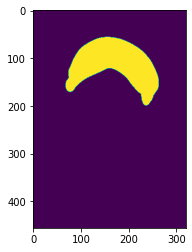

In [8]:
hippmask = nib.load(f'../ABA_v3_hippunfold3/hippunfold/sub-01/anat/sub-01_hemi-L_space-T1w_desc-subfields_atlas-multihist7_dseg.nii.gz').get_fdata() >0
# hippmask = hippmask + nib.load(f'../ABA_v3_hippunfold3/hippunfold/sub-01/anat/sub-01_hemi-R_space-T1w_desc-subfields_atlas-multihist7_dseg.nii.gz').get_fdata() >0
sphere = rg.sphere(9,5)
hippmask = binary_dilation(hippmask,sphere)
plt.imshow(hippmask[:,200,:])

In [9]:
ref_orig = nib.load('../ABA_v3/sub-01/anat/sub-01_T1w.nii.gz')
shp = ref_orig.header.get_data_shape()
print(shp)
print(ref_orig.affine)
affine_notransl = copy.deepcopy(ref_orig.affine)
affine_notransl[:3,3] = 0 # remove offset

(456, 528, 320)
[[ 0.025       0.          0.         -5.69999981]
 [ 0.          0.025       0.         -7.82499981]
 [ 0.          0.          0.025      -2.82500005]
 [ 0.          0.          0.          1.        ]]


In [10]:
allcoords = []
allclusters = []
allIDs = []

def checkmask(i):
    return hippmask[coordsi[i,0],coordsi[i,1],coordsi[i,2]]

for sub in [1,2,3,4]:
    dfcoords = pd.read_csv(f"ccf_coordinates_ABCA-{sub}.csv")
    dfclass = pd.read_csv(f"cell_metadata_ABCA-{sub}.csv")
    [common,iclass,icoord] = np.intersect1d(dfclass['cell_label'], dfcoords['cell_label'], return_indices=True)
    coords = dfcoords[['z','x','y']].to_numpy()[icoord,:]
    clusters = dfclass['cluster_alias'].to_numpy()[iclass]
    IDs = dfclass['cell_label'].to_numpy()[iclass]
    
    # apply inverse transform to move coords to matrix space
    coords = (np.linalg.inv(affine_notransl) @ np.concatenate((coords.T,np.ones((1,len(coords)))),axis=0)).T[:,:3]
    # flip
    coords[:,1] = shp[1]-coords[:,1]
    coords[:,2] = shp[2]-coords[:,2]
    
    # keep only points inside the hippocmapal mask
    coordsi = coords.astype(int)
    keep = checkmask(range(len(coords)))
    keep = np.where(keep==1)[0]
    coords = coords[keep,:]
    clusters = clusters[keep]
    IDs = IDs[keep]
    
    allcoords.append(coords)
    allclusters.append(clusters)
    allIDs.append(IDs)

In [11]:
allcoords = np.vstack(allcoords)
allclusters = np.hstack(allclusters)

print(np.min(allcoords,axis=0))
print(np.max(allcoords,axis=0))
allcoords.shape 

[ 54.0194362  122.00853805  60.06234187]
[230.98445856 290.95830653 268.99544076]


(473645, 3)

In [26]:
np.savez('checkpoint1',allcoords, allclusters, allIDs, allow_pickle=True)

In [4]:
dat = np.load('checkpoint1.npz',allow_pickle=True)
allcoords = dat[dat.files[1]]
allclusters = dat[dat.files[2]]
allIDs = dat[dat.files[3]]

In [12]:
# verify that this is in matrix space

outvol = griddata(allcoords, allclusters, np.mgrid[0:shp[0], 0:shp[1], 0:shp[2]].reshape([3,-1]).T, method='nearest')
outvol = outvol.reshape([shp[0],shp[1],shp[2]]).astype(float)
outvol[228:,:,:]=0
nib.save(nib.Nifti1Image(outvol,ref_orig.affine),"testClusters.nii.gz")

In [13]:
hipp = nib.load("../ABA_v3_hippunfold3/hippunfold/sub-01/surf/sub-01_hemi-L_space-T1w_den-0p5mm_label-hipp_midthickness.surf.gii").darrays[1].data
V = hipp[:,:]
V = (np.linalg.inv(ref_orig.affine) @ np.concatenate((V.T,np.ones((1,len(V)))),axis=0)).T[:,:3]
print(np.min(V,axis=0))
print(np.max(V,axis=0))

[ 67.06830878 136.45383632  74.28170093]
[223.00641532 279.38595594 254.64816668]


In [14]:
# verify that this is in matrix space

outvol2 = np.zeros(shp)
Vint = V.astype(int)
for i in range(len(V)):
    outvol2[Vint[:,0],Vint[:,1],Vint[:,2]] = 1.
outvol2[228:,:,:]=0
nib.save(nib.Nifti1Image(outvol2,ref_orig.affine),"testHippMidthick.nii.gz")

In [61]:
# Create surfaces at various depths
celltypes = np.unique(allclusters)
dist_threshold = 2 #voxels
hipp_dat = np.zeros([nV,len(depths), len(celltypes)])
!mkdir -p "../ABA_v3_hippunfold3/hippunfold/sub-01/surf/depths"
for l,layer in enumerate(depths):
    cmd1 = f'wb_command -surface-cortex-layer '\
        f'../ABA_v3_hippunfold3/hippunfold/sub-01/surf/sub-01_hemi-L_space-T1w_den-0p5mm_label-hipp_inner.surf.gii '\
        f'../ABA_v3_hippunfold3/hippunfold/sub-01/surf/sub-01_hemi-L_space-T1w_den-0p5mm_label-hipp_outer.surf.gii '\
        f'{layer} '\
        f'../ABA_v3_hippunfold3/hippunfold/sub-01/surf/depths/sub-01_hemi-L_space-T1w_den-0p5mm_label-hipp_layer-{layer}.surf.gii'
    !{cmd1}
    gii = nib.load(f'../ABA_v3_hippunfold3/hippunfold/sub-01/surf/depths/sub-01_hemi-L_space-T1w_den-0p5mm_label-hipp_layer-{layer}.surf.gii')
    V = gii.darrays[1].data
    V = (np.linalg.inv(ref_orig.affine) @ np.concatenate((V.T,np.ones((1,len(V)))),axis=0)).T[:,:3]
    
    for c,celltype in enumerate(celltypes):
        for v in range(len(V)):
            idx = np.where(allclusters==celltype)[0]
            dist = np.sqrt((V[v,0]-allcoords[idx,0])**2 + (V[v,1]-allcoords[idx,1])**2 + (V[v,2]-allcoords[idx,2])**2)
            hipp_dat[v,l,c] += np.sum(dist<dist_threshold)

In [62]:
np.save("checkpoint2",hipp_dat, allow_pickle=True)

In [3]:
hipp_dat = np.load('checkpoint2.npy',allow_pickle=True)

In [9]:
# OPTIONAL: smooth the data horizontally

hipp_flat_smooth = np.zeros((hipp_dat.shape))

for d in range(len(depths)):
    hipp_flat = np.nanmean(hipp_dat[:,d,:],axis=1)

    image = nib.gifti.GiftiImage()
    data_array = nib.gifti.GiftiDataArray(data=hipp_flat.astype(np.float32))
    image.add_gifti_data_array(data_array)
    nib.save(image,'hipp_flat.func.gii')
    cmd = "wb_command -metric-smoothing "\
        "../ABA_v3_hippunfold3/hippunfold/sub-01/surf/sub-01_hemi-L_space-T1w_den-0p5mm_label-hipp_midthickness.surf.gii "\
        "hipp_flat.func.gii 0.25 hipp_flat_smooth.func.gii"
    out = !{cmd}

    gii = nib.load('hipp_flat_smooth.func.gii')
    for k in range(len(gii.darrays)):
        hipp_flat_smooth[:,d,k] = gii.darrays[k].data

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


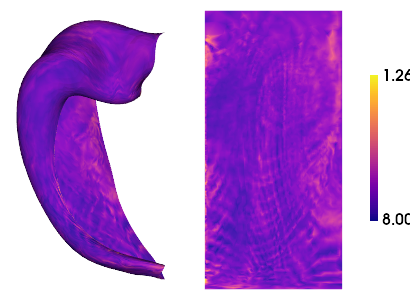

In [4]:
hm.plotting.surfplot_canonical_foldunfold(np.sum(hipp_dat,axis=(1,2)), labels=labels, hemis=['L'], unfoldAPrescale=True, den=den, cmap='plasma', color_bar='right', share='row',  tighten_cwindow=False, embed_nb=True)

(133,)

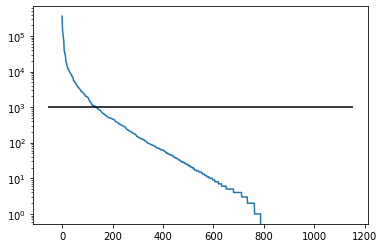

In [5]:
numcellscutoff = 10**3

plt.plot(np.sort(np.sum(hipp_dat,axis=(0,1)))[::-1]);
plt.gca().set_yscale('log')
plt.hlines(numcellscutoff, plt.gca().get_xbound()[0], plt.gca().get_xbound()[1],'k')

idx_cellskeep = np.where(np.sum(hipp_dat,axis=(0,1))>numcellscutoff)[0]
idx_cellskeep.shape

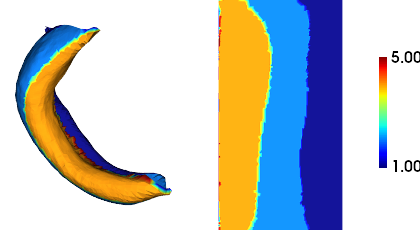

In [6]:
ABAsubfs = nib.load(f"{hippunfold_dir}/sub-01/surf/sub-01_hemi-L_space-T1w_den-0p5mm_label-hipp_atlas-ABA_subfields.label.gii").darrays[0].data

ABAsubfs_remap = np.ones_like(ABAsubfs)
ABAsubfs_remap[ABAsubfs==475] = 5
ABAsubfs_remap[ABAsubfs==467] = 4
ABAsubfs_remap[ABAsubfs==462] = 3
ABAsubfs_remap[ABAsubfs==457] = 2
data_array = nib.gifti.GiftiDataArray(data=ABAsubfs_remap)
image = nib.gifti.GiftiImage()
image.add_gifti_data_array(data_array)
nib.save(image, f"{hippunfold_dir}/sub-01/surf/sub-01_hemi-L_space-T1w_den-0p5mm_label-hipp_atlas-ABA_subfields-remap.shape.gii")
    
hm.plotting.surfplot_sub_foldunfold(hippunfold_dir, sub='01', ses='', features=['subfields-remap'], color_bar=('right'), hemis=['L'], labels=['hipp'], rotate=120, cmap='jet', unfoldAPrescale=True, share='row', tighten_cwindow=False, embed_nb=True)

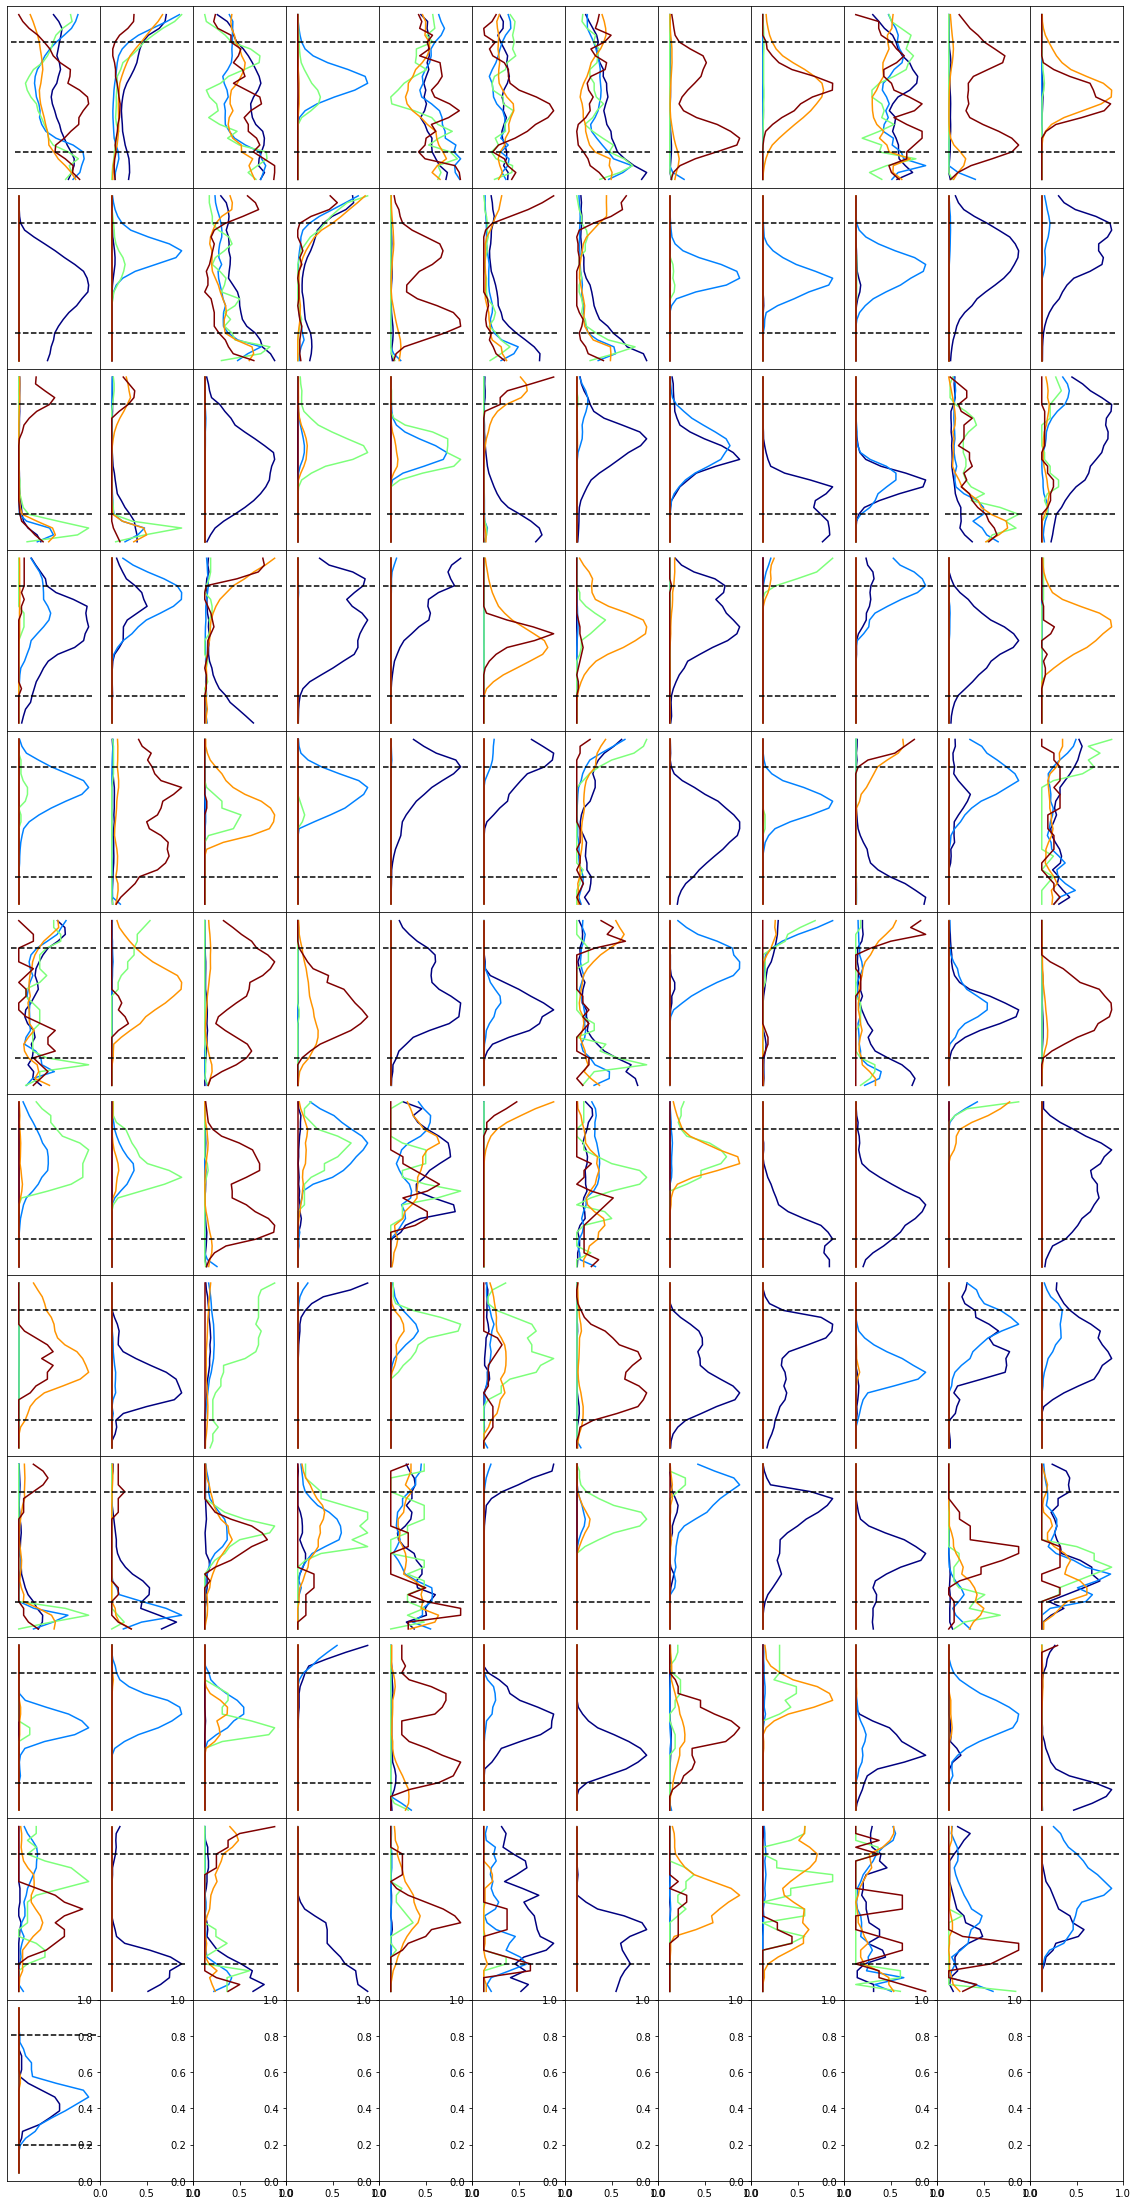

In [7]:
fig, ax = plt.subplots(nrows=12, ncols=12, figsize=(20,40))
col = plt.cm.jet(np.linspace(0,1,5))    

for i,idx in enumerate(np.argsort(np.sum(hipp_dat[:,:,idx_cellskeep],axis=(0,1)))[::-1]): # a complicated way of saying plot from most-to-least common cell type
    for s,sub in enumerate(np.unique(ABAsubfs_remap)):
        dat = np.mean(hipp_dat[:,:,idx_cellskeep[idx]][ABAsubfs_remap==sub,:],axis=0)
        ax[int(np.floor(i/12)),i%12].plot(dat,depths, color=col[s])
    ax[int(np.floor(i/12)),i%12].tick_params(left = False, right = False , labelleft = False ,
           labelbottom = False, bottom = False)
    ax[int(np.floor(i/12)),i%12].plot(ax[int(np.floor(i/12)),i%12].get_xlim(),[0,0],'k--')
    ax[int(np.floor(i/12)),i%12].plot(ax[int(np.floor(i/12)),i%12].get_xlim(),[1,1],'k--')

plt.subplots_adjust(wspace=0, hspace=0)

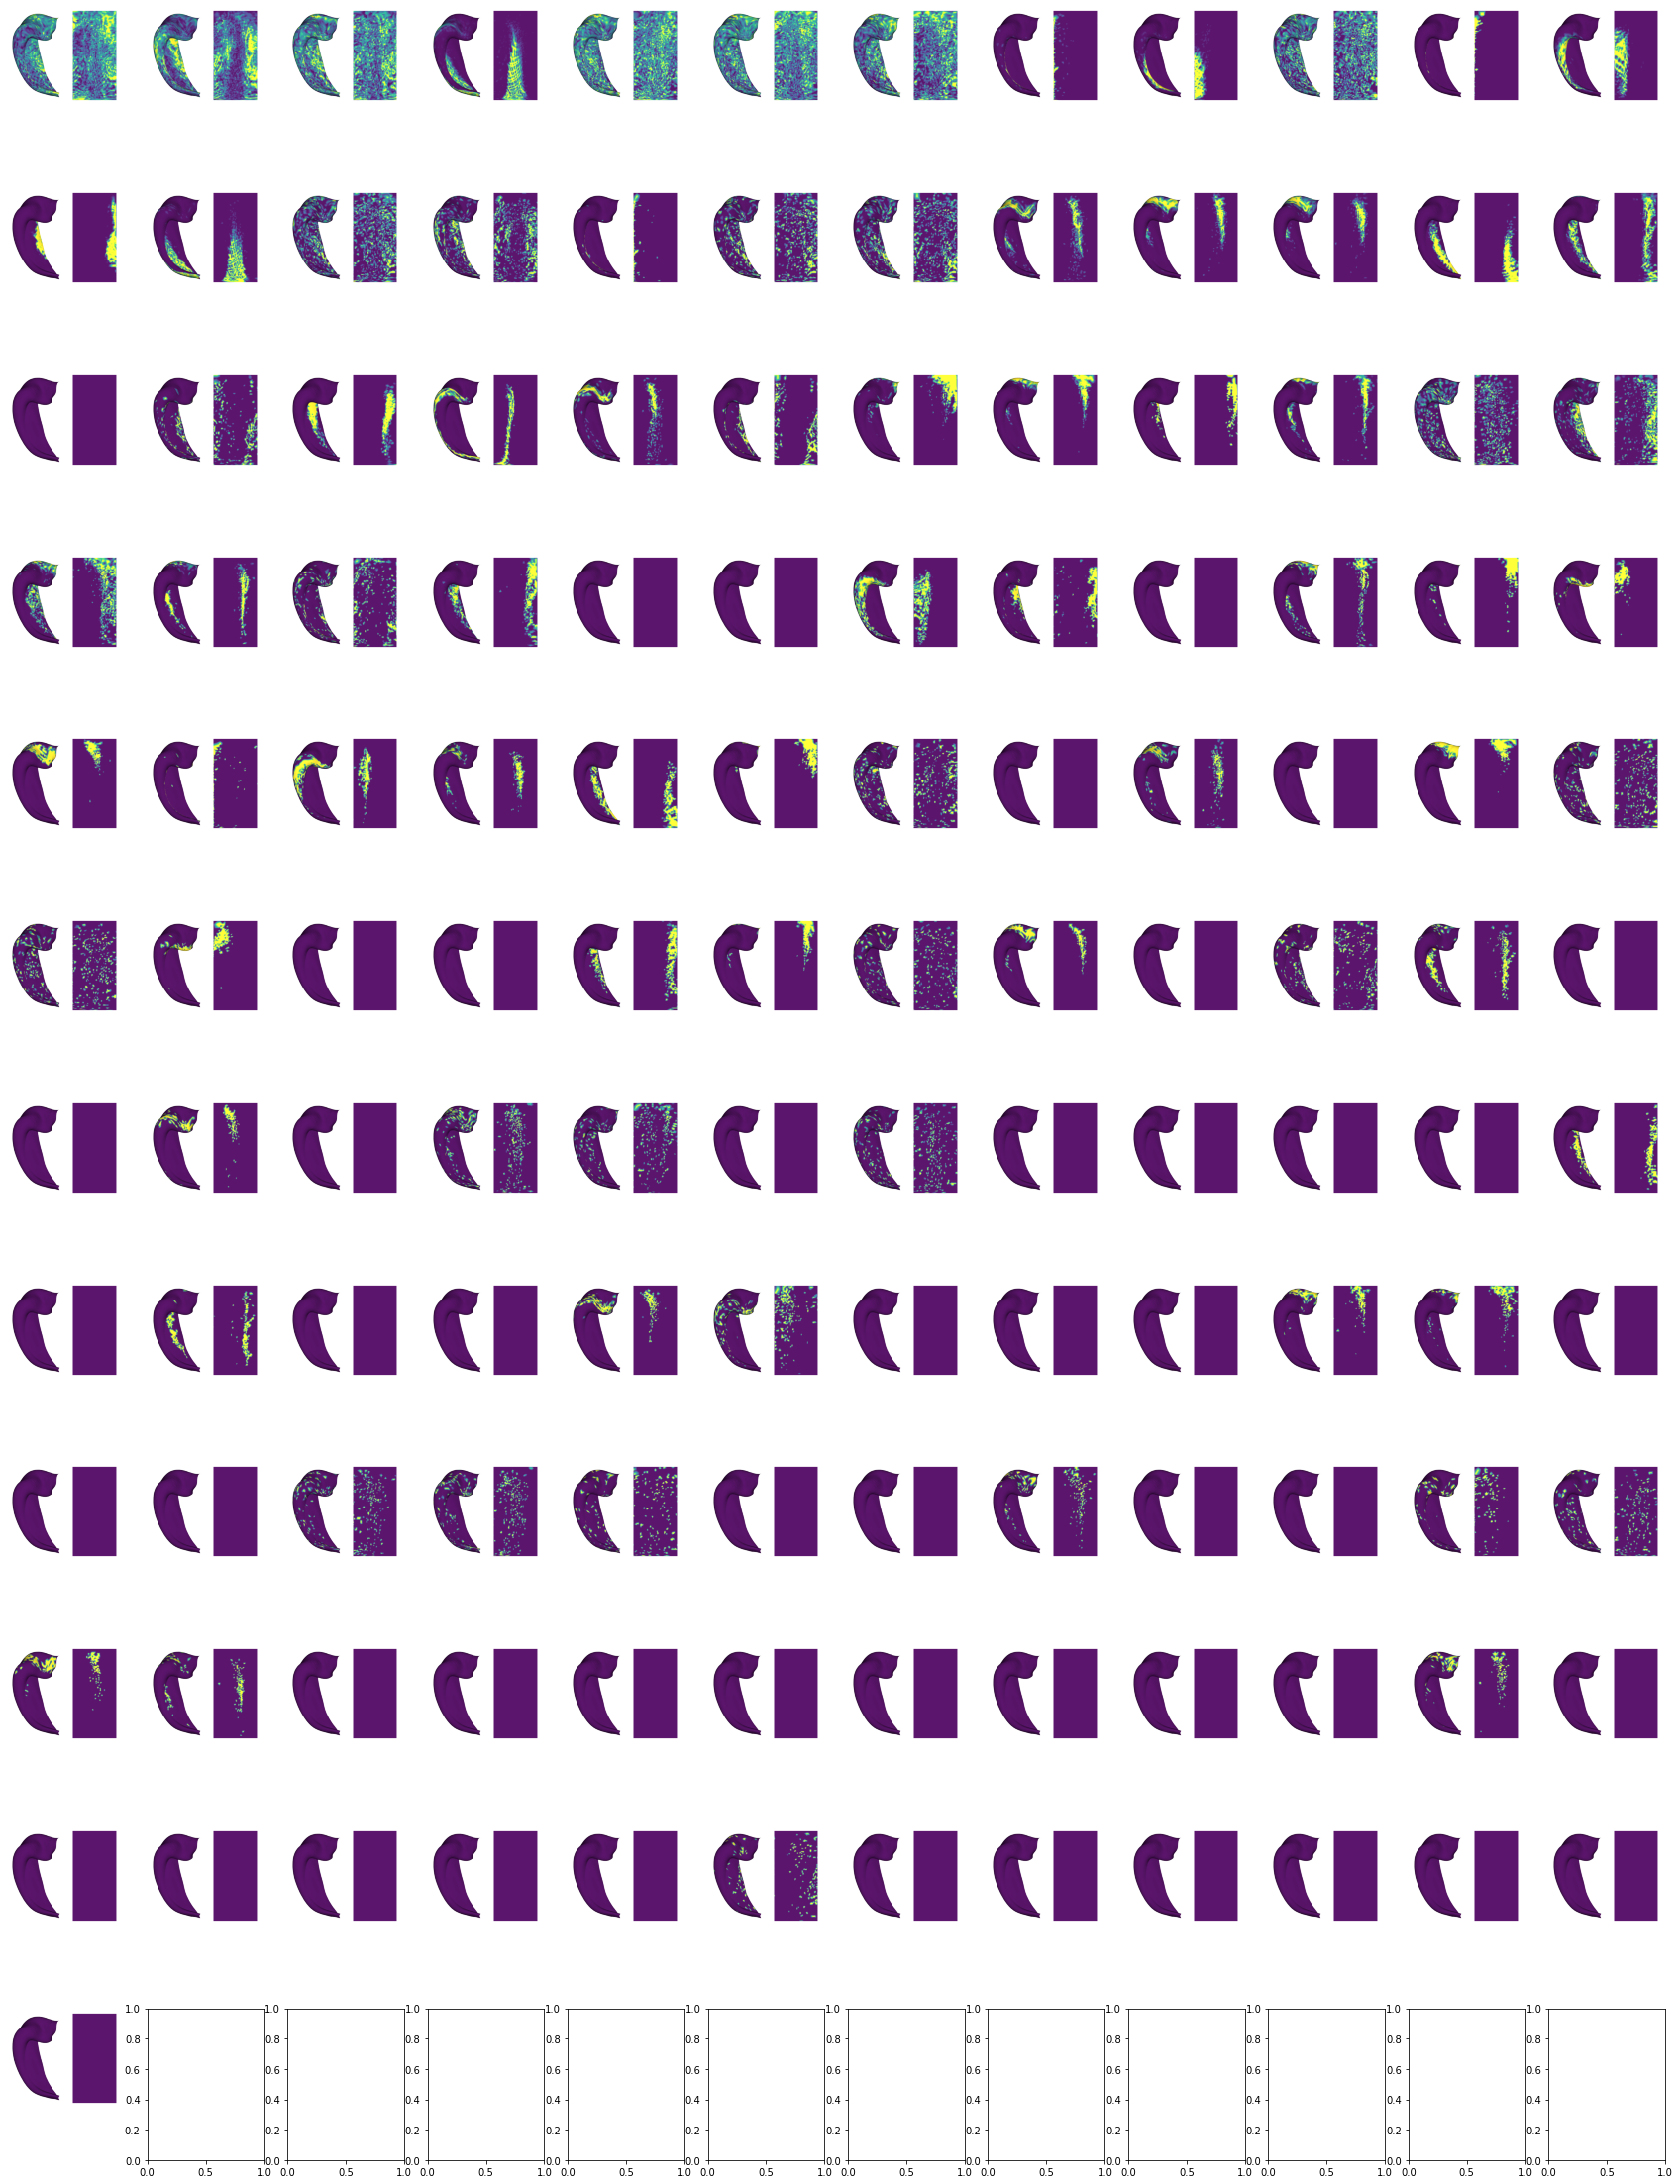

In [8]:
fig, ax = plt.subplots(nrows=12, ncols=12, figsize=(30,40))

for i,idx in enumerate(np.argsort(np.sum(hipp_dat[:,:,idx_cellskeep],axis=(0,1)))[::-1]): # a complicated way of saying plot from most-to-least common cell type
    plotdat = np.mean(hipp_dat[:,:,idx_cellskeep[idx]][:,gm],axis=1)
    hm.plotting.surfplot_canonical_foldunfold(plotdat, labels=labels, hemis=['L'], unfoldAPrescale=True, den=den, tighten_cwindow=True, embed_nb=True, screenshot=True, filename=f'tmp.png')
    f = plt.imread(f'tmp.png')
    ax[int(i/12),i%12].imshow(f)
    ax[int(i/12),i%12].set_axis_off()
    ax[int(i/12),i%12].set_anchor("NW")

# MPCs

In [24]:
# here, we will use a few more tools (build_mpc is borrowed from micapipe)

from hippomaps.build_mpc import build_mpc
from brainspace.gradient import GradientMaps

In [29]:
mMP = np.reshape(hipp_dat[:,gm,:][:,:,idx_cellskeep],(nV,-1)) #flatten. Each vertex now has a vector of depths for all modalities.
mMPC, I, problemNodes = build_mpc(mMP.T) # compute mMPC

(-0.5, 7261.5, 7261.5, -0.5)

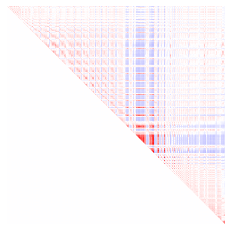

In [30]:
# plot the mMPC to get a sense of similarity between vertices.
plt.imshow(mMPC, vmin=-1, vmax=1, cmap='bwr')
plt.axis('off')

In [31]:
# multimodal gradient map (mGM) decomposition using default parameters
mGM = GradientMaps(n_components=5)
mGM.fit(mMPC)

GradientMaps(n_components=5)

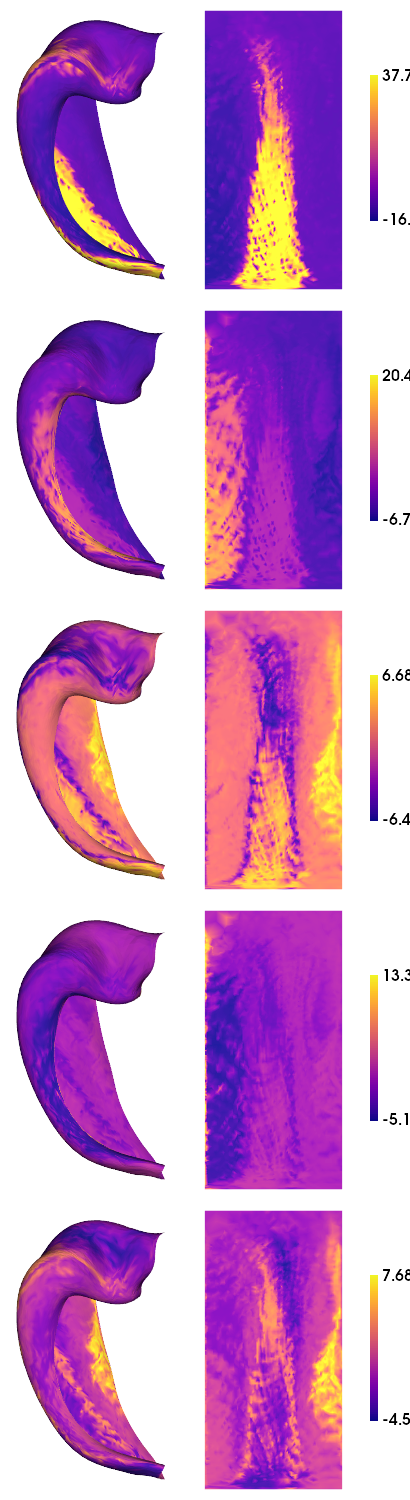

In [32]:
# As above, we can make a nice plot for each of the resulting gradients
hm.plotting.surfplot_canonical_foldunfold(mGM.gradients_, labels=labels, hemis=['L'], unfoldAPrescale=True, den=den, cmap='plasma', color_bar='right', share='row',  tighten_cwindow=False, embed_nb=True)

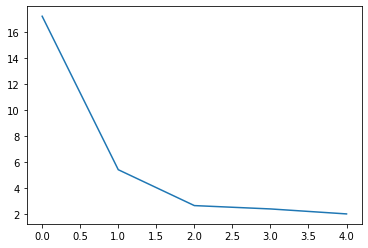

In [78]:
# we can also see the lambda value (or eigenvalue) for each gradient
plt.plot(mGM.lambdas_)

# retroactively look at cluster SCORE gradients

In [102]:
import anndata as ad
adata = ad.read('Zhuang-ABCA-1-log2.h5ad', backed='r')
adata

AnnData object with n_obs × n_vars = 4167870 × 1122 backed at 'Zhuang-ABCA-1-log2.h5ad'
    obs: 'brain_section_label'
    var: 'gene_symbol'
    uns: 'normalization'

In [119]:
adata.to_df()

gene_identifier,ENSMUSG00000024798,ENSMUSG00000042385,ENSMUSG00000036198,ENSMUSG00000028780,ENSMUSG00000015843,ENSMUSG00000026768,ENSMUSG00000049928,ENSMUSG00000041046,ENSMUSG00000032373,ENSMUSG00000004633,...,ENSMUSG00000024064,ENSMUSG00000035580,ENSMUSG00000010136,ENSMUSG00000024376,ENSMUSG00000022324,ENSMUSG00000015619,ENSMUSG00000070047,ENSMUSG00000002266,ENSMUSG00000036111,ENSMUSG00000033063
cell_label,,,,,,,,,,,,,,,,,,,,,
193941736402251606107833307525726535840,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.803657,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
85091201945847241256839036055585241313,0.000000,0.0,0.0,0.812592,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.812592,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
59989714095999997980989677465064089207,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
44660302634839678938820472698179064243,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
205362668827699772934470483685067575970,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282028029999399922205427625178942946817,0.487017,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.588671,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.850470,0.0,0.000000,0.0
94693764385329893593037999127221531986,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.785366,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.785366,0.0
174390422472124560356033685162365661873,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.074768,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


In [95]:
allcluster_scores = []
for sub in [1,2,3,4]:
    dfclass = pd.read_csv(f"cell_metadata_ABCA-{sub}.csv")
    [a,keep,c] = np.intersect1d(dfclass['cell_label'], allIDs[sub-1][idx_cellskeep], return_indices=True)
    allcluster_scores.append(dfclass['cluster_confidence_score'][keep])

In [ ]:
# cool gif

# import imageio.v3 as iio
# import matplotlib as mpl
# from pygifsicle import optimize

# fig1 = plt.figure(figsize = (20,20)) # create a figure with the default size 
# skip=3

# cmap = plt.cm.jet
# cmaplist = [cmap(i) for i in range(cmap.N)]
# cmaplist = np.array(cmaplist)
# cmaplist = cmaplist[np.random.randint(0,cmaplist.shape[0],cmaplist.shape[0]),:]
# cmap = mpl.colors.LinearSegmentedColormap.from_list(
#     'Custom cmap', cmaplist, cmap.N)
# outvol[outvol==0] = np.nan
# !rm CellTypes.gif

# n=0
# for i in range(0,outvol.shape[1],skip):
#     im1 = plt.imshow(ref_orig.get_fdata()[:,i,:].T,cmap='gray')
#     im2 = plt.imshow(outvol[:,i,:].T,cmap=cmap, clim=[1,34380], interpolation='none')
#     plt.gca().invert_yaxis()
#     plt.gca().invert_xaxis()
#     plt.axis('off')
#     plt.savefig(f'foo{n}.png')
#     n=n+1
# for i in range(outvol.shape[1]-1,0,-skip):
#     im1 = plt.imshow(ref_orig.get_fdata()[:,i,:].T,cmap='gray')
#     im2 = plt.imshow(outvol[:,i,:].T,cmap=cmap, clim=[1,34380], interpolation='none')
#     plt.gca().invert_yaxis()
#     plt.gca().invert_xaxis()
#     plt.axis('off')
#     n=n+1
#     plt.savefig(f'foo{n}.png')

# t = np.linspace(0,n,n+1)
# t = np.delete(t,176)
# t = t.astype(int)
# frames = np.stack([iio.imread(f"foo{x}.png") for x in t], axis=0)
# iio.imwrite("CellTypes.gif", frames, loop=0)
# !rm foo*.png